In [34]:
import re
import xarray
import rioxarray
import pandas as pd
import geopandas as gpd

storage_directory = "/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/DGM"

In [67]:
polygons = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/brandenburg_polygons.geojson")
polygons["terrain_suitability"] = pd.NA

In [70]:
polygons.dissolve(by = "link_id", as_index = False).link_id[[1]]

1    BB_ML_0001
Name: link_id, dtype: object

In [22]:
grids = xarray.open_dataset("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/BB_ML_0001_2017-06-02.nc",
                    drop_variables = ["red", "green", "blue"]).attrs["grids"]

In [24]:
xr = xarray.combine_by_coords([rioxarray.open_rasterio(storage_directory + "/raw/dgm_" + grid.replace("_", "-")  + ".xyz") for grid in grids])
xr.rio.write_crs("25833", inplace = True)

<xarray.DataArray (band: 1, y: 2002, x: 3003)>
array([[[44.683, 44.69 , 44.732, ..., 36.284, 36.29 , 36.304],
        [44.717, 44.724, 44.741, ..., 36.308, 36.305, 36.304],
        [44.736, 44.759, 44.767, ..., 36.318, 36.317, 36.315],
        ...,
        [36.448, 36.446, 36.399, ..., 38.067, 38.073, 38.099],
        [36.392, 36.434, 36.42 , ..., 38.072, 38.1  , 38.116],
        [36.376, 36.387, 36.403, ..., 38.04 , 38.108, 38.138]]],
      dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.13e+05 4.13e+05 4.13e+05 ... 4.16e+05 4.16e+05
  * y            (y) float64 5.797e+06 5.797e+06 ... 5.799e+06 5.799e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [39]:
id = re.search(re.compile("(?<=imagery/)\w\w_\w\w_\w\w\w\w"), "/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/BB_ML_0001_2017-06-02.nc").group(0)
state_name = re.search(re.compile("(?<=imagery/)\w\w"), "/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/BB_ML_0001_2017-06-02.nc").group(0)

In [20]:
def worker(x):
    tmp = xr.rio.clip([x])
    return (1 - (tmp.std() / (tmp.max() - tmp.min()))).values

In [38]:
polygons.loc[polygons.link_id == id, "terrain_suitability"] = polygons[polygons.link_id == id].geometry.apply(worker)

In [40]:
polygons.loc[:, ["link_id", "terrain_suitability"]].to_csv(storage_directory + "/" + state_name + ".csv")

---
# Legacy

In [1]:
from owslib.wms import WebMapService

In [2]:
wms = WebMapService("https://isk.geobasis-bb.de/mapproxy/dgm/service/wms", version='1.3.0')

In [69]:
[op.name for op in wms.operations]

['GetCapabilities', 'GetMap', 'GetFeatureInfo', 'GetLegendGraphic']

In [75]:
wms.getOperationByName('GetLegendGraphic').

In [76]:
wms

OrderedDict([('dgm', <owslib.map.wms130.ContentMetadata at 0x153e9a37cf40>)])

In [20]:
list(wms.contents)

['dgm']

In [82]:
# @https://gis.stackexchange.com/questions/429209/how-to-get-more-information-about-the-legend-of-a-wms
def layer_report(service, layer_name):
  print(f"WMS general info:\n")
  print(f"WMS version: {service.identification.version}")
  print(f"WMS title: {service.identification.title}")
  print(f"WMS abstract: {service.identification.abstract}")
  print(f"Provider name: {service.provider.name}")
  print(f"Provider address: {service.provider.contact.address}")
  print(f"\nLayer info:\n")
  print('- Title: ', service.contents[layer_name].title)
  print('- BoundingBox: ', service.contents[layer_name].boundingBox)
  print('- BoundingBoxWGS84: ', service.contents[layer_name].boundingBoxWGS84)
  print('- CrsOptions: ', service[layer_name].crsOptions)
  print('- Format Options: ', service.getOperationByName('GetMap').formatOptions)
  print('- Layer styles: ', service[layer_name].styles)
  print('- Operations ', [op.name for op in service.operations])

In [83]:
layer_report(wms, "dgm")

WMS general info:

WMS version: 1.3.0
WMS title: WMS BB-BE DGM 1m Cache
WMS abstract: Dieser Web Map Service ist ein gekachelter Kartendienst zur schnellen Anzeige, welcher als Datengrundlage das digitale Geländemodell (Laserscan) mit der Bodenauflösung von 1m vom Gebiet Brandenburg mit Berlin hat.
Provider name: Landesvermessung und Geobasisinformation Brandenburg
Provider address: Heinrich-Mann-Allee 104 B

Layer info:

- Title:  Digitales Geländemodell 1m Bodenauflösung Cache Brandenburg mit Berlin (WMS)
- BoundingBox:  (11.152768795679583, 51.263517011631606, 15.392977959312176, 53.60940433664921, 'CRS:84')
- BoundingBoxWGS84:  (11.152768795679583, 51.263517011631606, 15.392977959312176, 53.60940433664921)
- CrsOptions:  ['EPSG:25832', 'EPSG:3034', 'EPSG:25833', 'EPSG:4839', 'EPSG:4326', 'EPSG:4258', 'EPSG:3857', 'EPSG:3035', 'EPSG:5650', 'EPSG:900913', 'EPSG:3045']
- Format Options:  ['image/jpeg', 'image/png', 'image/gif']
- Layer styles:  {'default': {'title': 'default', 'legend

In [3]:
bbox = (394168.38, 5796138.69, 394388.69, 5796390.61)

In [4]:
def __calculate_image_size(bbox, pixel_density):
        return([((bbox[2] - bbox[0]) / pixel_density), 
                ((bbox[3] - bbox[1]) / pixel_density)])

In [5]:
__calculate_image_size(bbox, 1)

[220.30999999999767, 251.9199999999255]

In [6]:
img = wms.getmap(layers = ["dgm"],
                srs = "EPSG:25833",
                bbox = bbox,
                size = __calculate_image_size(bbox, 1),
                format = "image/jpeg").read()

In [1]:
import requests

page = requests.get("https://data.geobasis-bb.de/geobasis/daten/dgm/xyz/")

In [2]:
from bs4 import BeautifulSoup
import re
soup = BeautifulSoup(page.content)

In [3]:
links = [elem["href"] for elem in soup.find_all("a", href = True, string = re.compile("dgm.*zip"))]

In [15]:
len(links)

32016

In [4]:
links[0]

'dgm_33250-5886.zip'

In [7]:
from urllib.request import urlretrieve
urlretrieve("https://data.geobasis-bb.de/geobasis/daten/dgm/xyz/" + links[0],
            "/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/DGM/raw/" + links[0])

('/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/DGM/raw/dgm_33250-5886.zip',
 <http.client.HTTPMessage at 0x14b20d393160>)

In [10]:
from zipfile import ZipFile
with ZipFile("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/DGM/raw/" + links[0], "r") as zip_ref:
                zip_ref.extractall("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/DGM/raw")

In [11]:
import xarray
import rioxarray
height = rioxarray.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/DGM/raw/dgm_33250-5886.xyz")

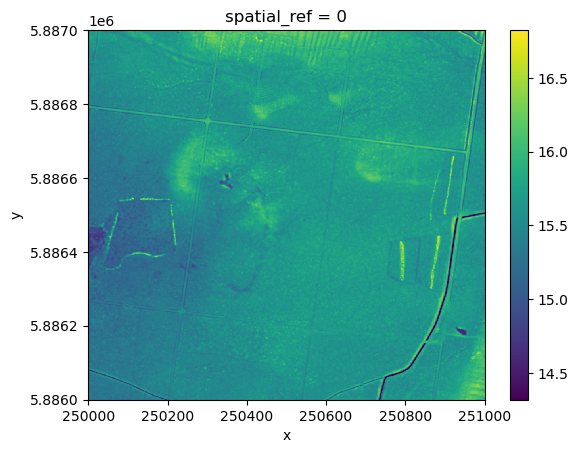

In [14]:
xarray.plot.imshow(height.squeeze("band", drop = True))

In [44]:
import xarray
import rioxarray
height = rioxarray.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/BB_ML_0045_2017-06-02.nc")

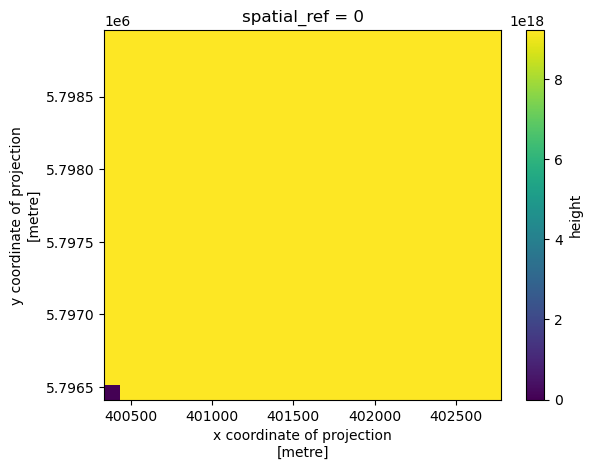

In [47]:
xarray.plot.imshow(height.height.squeeze("band", drop = True))

In [8]:
filenames = [re.search(re.compile(".*(?=\.zip)"), link).group(0) for link in links]

In [10]:
# create a lookup table
"/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/DGM/raw/" + filenames[0] + ".xml"

'/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/DGM/raw/dgm_33250-5886.xml'

In [41]:
test = [["/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/DGM/raw/" + file + ".xml" for file in filenames][0]]

In [42]:
def worker(file):
    out = pd.read_xml(file, xpath = "//Extent/sw|//Extent/se|//Extent/nw|//Extent/ne")
    out["id"] = file
    out["pos"] = ["sw", "se", "nw", "ne"]
    return out
pd.concat([worker(file) for file in test])

,x,y,id,pos
0,249948.813685,5.886004e+06,/pfs/work7/workspace/scratch/tu_zxobe27-ds_pro...,sw
1,251000.247909,5.885949e+06,/pfs/work7/workspace/scratch/tu_zxobe27-ds_pro...,se
2,251054.513774,5.886994e+06,/pfs/work7/workspace/scratch/tu_zxobe27-ds_pro...,nw
3,250003.309164,5.887049e+06,/pfs/work7/workspace/scratch/tu_zxobe27-ds_pro...,ne


In [31]:
import pandas as pd
out = pd.read_xml("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/DGM/raw/" + filenames[0] + ".xml", xpath = "//Extent/sw|//Extent/se|//Extent/nw|//Extent/ne")
out["id"] = filenames[0]
out["pos"] = ["sw", "se", "nw", "ne"]
out

,x,y,id,pos
0,249948.813685,5.886004e+06,dgm_33250-5886,sw
1,251000.247909,5.885949e+06,dgm_33250-5886,se
2,251054.513774,5.886994e+06,dgm_33250-5886,nw
3,250003.309164,5.887049e+06,dgm_33250-5886,ne


In [19]:
{soup.Extent.}

<Extent srs="25833">
<sw x="249948.813685" y="5886003.9988143"/>
<se x="251000.247909" y="5885949.2903619"/>
<ne x="251054.5137739" y="5886994.3631638"/>
<nw x="250003.3091636" y="5887049.0664141"/>
</Extent>

In [22]:
soup.Extent.se

<se x="251000.247909" y="5885949.2903619"/>

In [21]:
[x for x in soup.Extent.se]

[]

In [1]:
import xarray
import rioxarray

In [3]:
xr = rioxarray.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/test.nc", masked_and_scale = True)

/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/ds_project/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/ds_project/lib/python3.10/site-packages/rioxarray/_io.py:924: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/ds_project/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/ds_p

In [4]:
xr

<xarray.Dataset>
Dimensions:      (band: 1, x: 12200, y: 5710)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.22e+04 1.22e+04 1.22e+04
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 5.708e+03 5.708e+03 5.71e+03
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
Attributes:
    grids:    [33413.]

In [2]:
xarray.open_dataset("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/test.nc")

<xarray.Dataset>
Dimensions:  (y: 5710, x: 12200)
Coordinates:
  * y        (y) float64 5.798e+06 5.798e+06 5.798e+06 ... 5.799e+06 5.799e+06
  * x        (x) float64 4.133e+05 4.133e+05 4.133e+05 ... 4.157e+05 4.157e+05
Data variables:
    red      (y, x) float64 ...
    green    (y, x) float64 ...
    blue     (y, x) float64 ...
Attributes:
    grids:    ['33413_5797', '33413_5798', '33414_5797', '33414_5798', '33415...

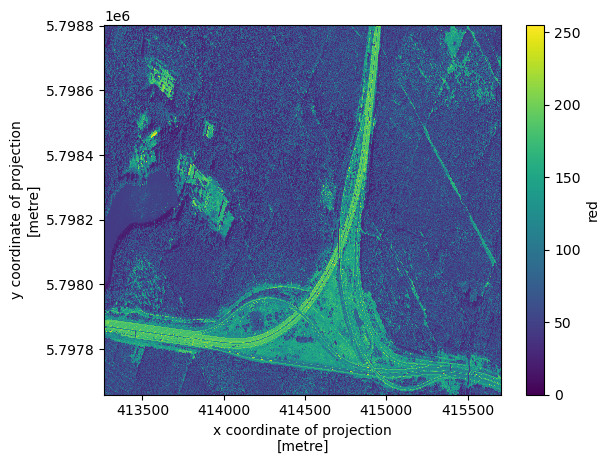

In [63]:
xarray.plot.imshow(xr.red.squeeze("band", drop = True).drop("spatial_ref"))

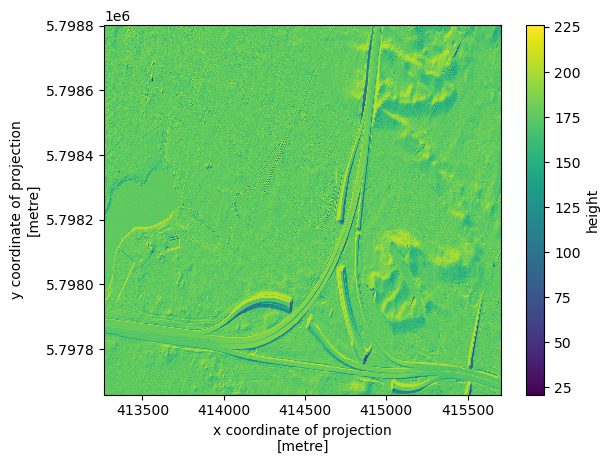

In [71]:
xarray.plot.imshow(xr.height.squeeze("band", drop = True).drop("spatial_ref"))

In [21]:
import geopandas as gpd
driveways_polygons = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/brandenburg_polygons.geojson")

<AxesSubplot: >

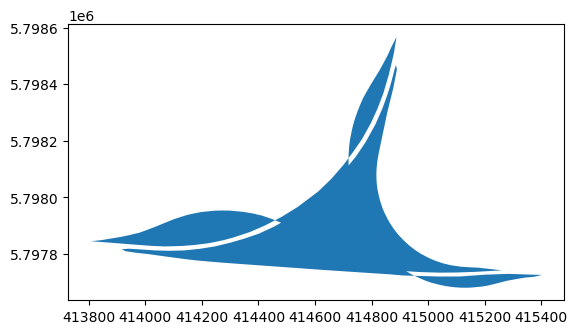

In [22]:
driveways_polygons.loc[driveways_polygons.link_id == "BB_ML_0001"].dissolve().plot()

In [78]:
100 - (xr.height.rio.clip(driveways_polygons.loc[driveways_polygons.link_id == "BB_ML_0001"].dissolve().geometry.values).std() / 255) * 100

<xarray.DataArray 'height' ()>
array(92.33878733)
Coordinates:
    spatial_ref  int64 0

In [86]:
test = driveways_polygons.loc[driveways_polygons.link_id == "BB_ML_0001"].copy()
test.geometry = test.geometry.apply(lambda x: x.buffer(-10))

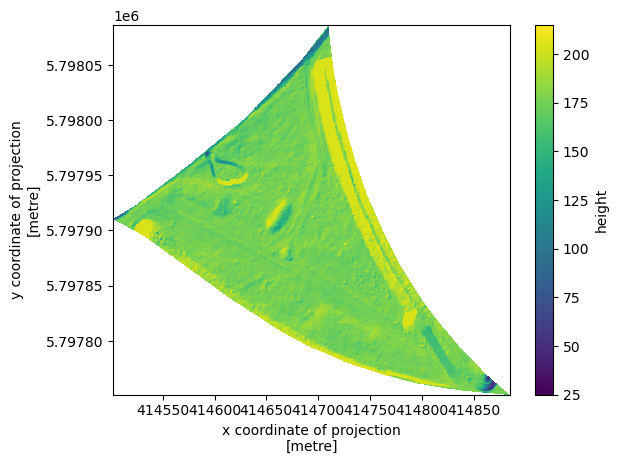

In [102]:
xarray.plot.imshow(xr.height.rio.clip(test.iloc[[3]].dissolve().geometry.values).squeeze("band", drop = True).drop("spatial_ref"))

In [99]:
100 - (xr.height.rio.clip(test.iloc[[2]].dissolve().geometry.values).std() / 25) * 100

<xarray.DataArray 'height' ()>
array(10.04846901)
Coordinates:
    spatial_ref  int64 0

In [40]:
xr.astype("int").height.rio.write_nodata(-1, encoded=True, inplace=True)

<xarray.DataArray 'height' (band: 1, y: 5710, x: 12200)>
array([[[-9223372036854775808, -9223372036854775808,
         -9223372036854775808, ..., -9223372036854775808,
         -9223372036854775808, -9223372036854775808],
        [-9223372036854775808, -9223372036854775808,
         -9223372036854775808, ..., -9223372036854775808,
         -9223372036854775808, -9223372036854775808],
        [-9223372036854775808, -9223372036854775808,
         -9223372036854775808, ..., -9223372036854775808,
         -9223372036854775808, -9223372036854775808],
        ...,
        [                 179,                  179,
                          179, ..., -9223372036854775808,
         -9223372036854775808, -9223372036854775808],
        [                 179,                  179,
                          179, ..., -9223372036854775808,
         -9223372036854775808, -9223372036854775808],
        [                 179,                  179,
                          179, ..., -9223372036854775808,
         -9223372036854775808, -9223372036854775808]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.133e+05 4.133e+05 ... 4.157e+05 4.157e+05
  * y            (y) float64 5.799e+06 5.799e+06 ... 5.798e+06 5.798e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [35]:
xr.height.rio.write_nodata(-1, encoded=True, inplace=True)
#xarray.plot.imshow(xr.height.rio.clip(driveways_polygons.loc[driveways_polygons.link_id == "BB_ML_0001"].dissolve().geometry.values).squeeze("band", drop = True).drop("spatial_ref"))

/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/ds_project/lib/python3.10/site-packages/rioxarray/raster_writer.py:115: UserWarning: The nodata value (-1.0) has been automatically changed to (18446744073709551615) to match the dtype of the data.
  warnings.warn(


<xarray.DataArray 'height' (band: 1, y: 5710, x: 12200)>
array([[[9223372036854775808, 9223372036854775808, ..., 9223372036854775808,
         9223372036854775808],
        [9223372036854775808, 9223372036854775808, ..., 9223372036854775808,
         9223372036854775808],
        ...,
        [                179,                 179, ..., 9223372036854775808,
         9223372036854775808],
        [                179,                 179, ..., 9223372036854775808,
         9223372036854775808]]], dtype=uint64)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.133e+05 4.133e+05 ... 4.157e+05 4.157e+05
  * y            (y) float64 5.799e+06 5.799e+06 ... 5.798e+06 5.798e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

(array([2.7720800e+05, 2.1172094e+07, 2.3956595e+07, 1.7142634e+07,
        5.4809320e+06, 1.3157690e+06, 2.0839200e+05, 2.5984000e+04,
        1.0654000e+04, 1.1400000e+02]),
 array([  8. ,  28.2,  48.4,  68.6,  88.8, 109. , 129.2, 149.4, 169.6,
        189.8, 210. ]),
 <BarContainer object of 10 artists>)

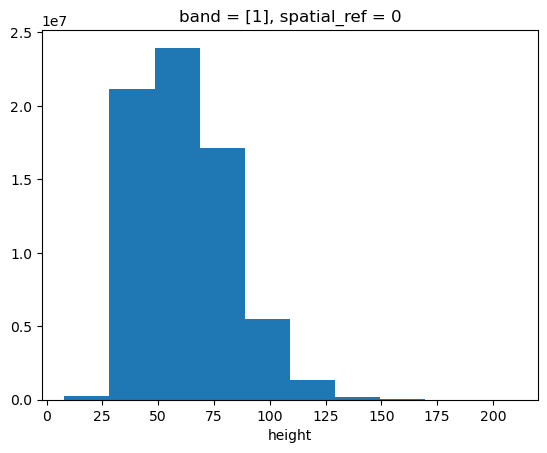

In [9]:
xr.height.where(xr.height < 4000).plot.hist()

In [ ]:
urlretrieve("http://re.jrc.ec.europa.eu/pvg_download/sarahdata/gh_0_year_sarah.zip",
            self.storage_directory + "/raw/gh_0_year_sarah.zip")

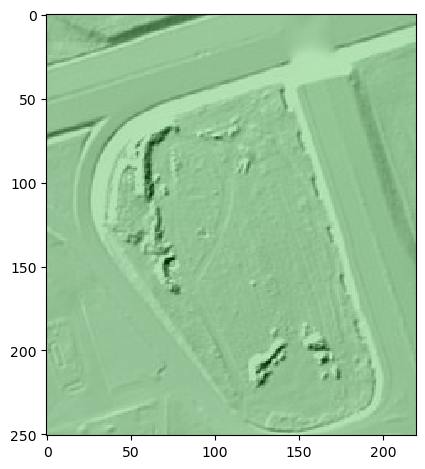

In [7]:
import io
import skimage
img_show = skimage.io.imread(io.BytesIO(img))
skimage.io.imshow(img_show)

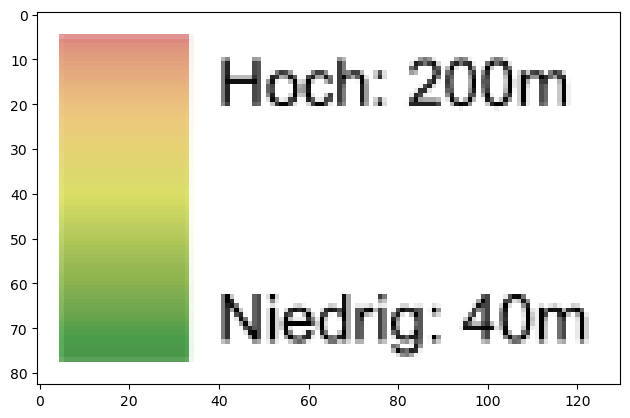

In [87]:
import requests
legend = requests.get("https://isk.geobasis-bb.de/mapproxy/dgm/service/wms?format=image%2Fpng&layer=dgm&sld_version=1.1.0&request=GetLegendGraphic&service=WMS&version=1.1.1") 
legend_show = skimage.io.imread(io.BytesIO(legend.content))
skimage.io.imshow(legend_show)

In [ ]:
# possible @TODO: match legend to get absolute height
legend_show[]

In [8]:
from skimage.color import rgb2gray
grayscale = rgb2gray(img_show)

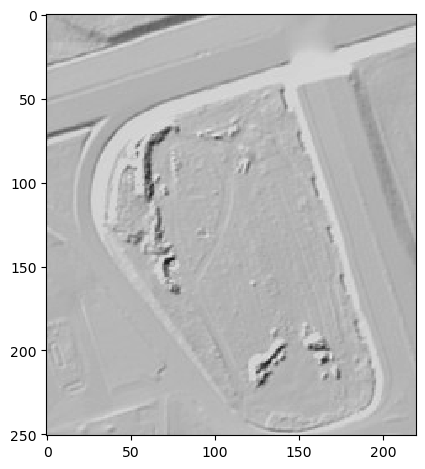

In [9]:
skimage.io.imshow(grayscale)

In [10]:
import xarray
import numpy as np

tmp_xd = xarray.Dataset(data_vars = {"height": (["x", "y"], grayscale[::-1,::])},
                 coords = {"x": (["x"], np.arange(grayscale.shape[0]) * 1 + bbox[0]),
                           "y": (["y"], np.arange(grayscale.shape[1]) * 1 + bbox[1])})

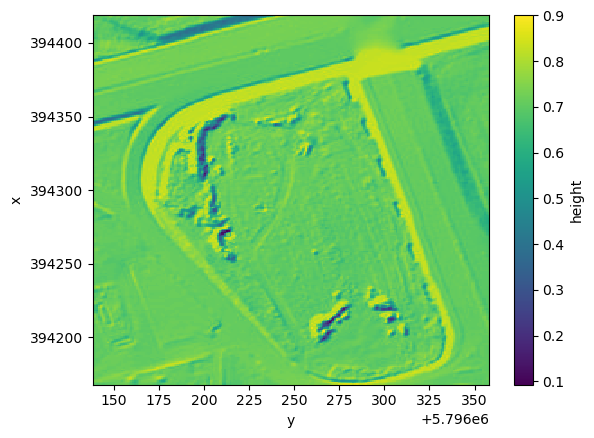

In [24]:
tmp_xd.height.plot()

In [25]:
tmp_xd.std()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    height   float64 0.06181

In [12]:
import xrspatial
tmp_xd_slope = xrspatial.slope(tmp_xd.height)
1 - tmp_xd_slope.std() / (tmp_xd_slope.max() - tmp_xd_slope.min())

<xarray.DataArray 'slope' ()>
array(0.91205028)

(array([4.6553e+04, 4.6480e+03, 1.3920e+03, 8.2800e+02, 4.6500e+02,
        2.1800e+02, 1.0200e+02, 4.4000e+01, 2.0000e+01, 1.2000e+01]),
 array([ 0.        ,  1.89055502,  3.78111005,  5.67166519,  7.5622201 ,
         9.452775  , 11.34333038, 13.23388481, 15.12444019, 17.01499557,
        18.90555   ]),
 <BarContainer object of 10 artists>)

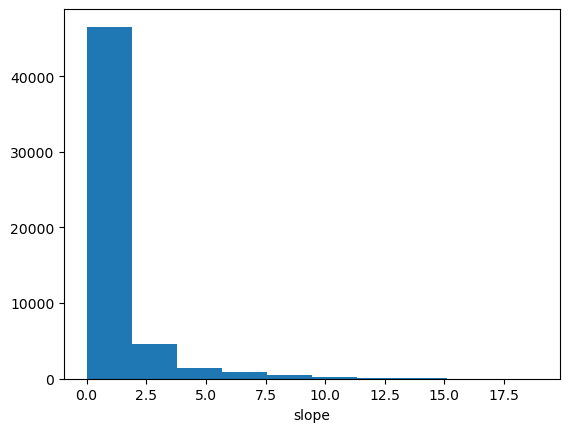

In [36]:
tmp_xd_slope.plot.hist()

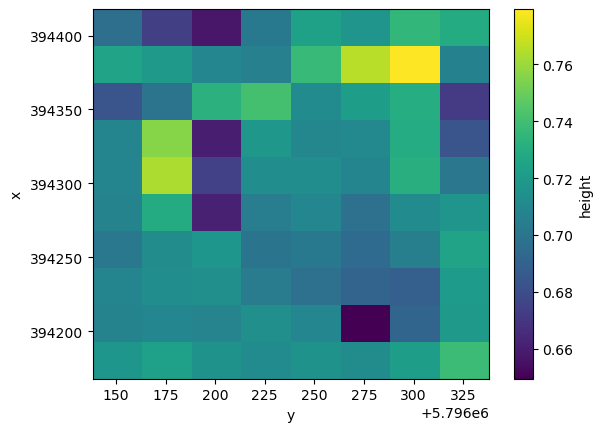

In [102]:
tmp_xd_coarsened = tmp_xd.coarsen({"x": 25, "y": 25}, boundary="trim").mean()
tmp_xd_coarsened.height.plot()

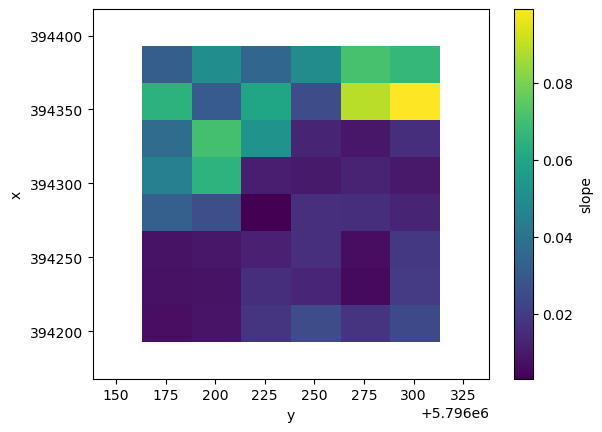

In [101]:
xrspatial.slope(tmp_xd_coarsened.height).plot()

# SRTM

In [109]:
tiles = [f"N{lat}E{lon}" for lat in np.arange(47, 54 + 1) for lon in ['{:03d}'.format(x) for x in np.arange(5, 15 + 1)]]


In [106]:
N 47 E 005
N 54 E015

'015'

In [167]:
execfile("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project/research/notebooks/earthdata_auth.py")

In [159]:
it_tile = tiles[0]
link = f"https://e4ftl01.cr.usgs.gov/DP133/SRTM/SRTMGL1.003/2000.02.11/{it_tile}.SRTMGL1.hgt.zip"
filename = f"/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/SRTM/raw/{it_tile}.hgt.zip"

with requests.Session() as session:
    s.auth = (username, password)

    r1 = session.request('get', link)

    r = session.get(r1.url, auth=(username, password))
    
    if r.status_code == 200:
      with open(filename, 'wb') as out:
         for bits in r.iter_content():
            out.write(bits)

In [160]:
from zipfile import ZipFile
with ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/SRTM/raw/")

In [1]:
import xarray
import rioxarray
height = rioxarray.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/SRTM/raw/N47E005.hgt")

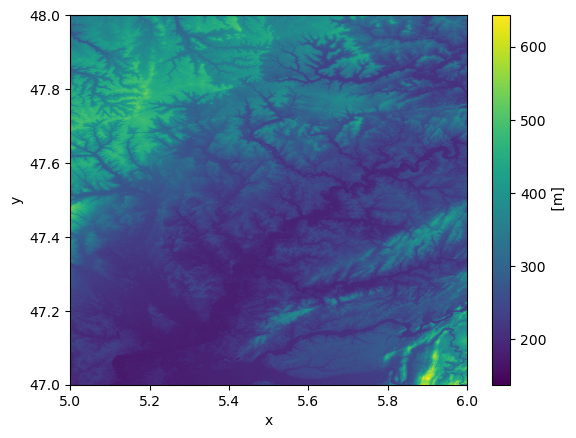

In [8]:
xarray.plot.imshow(height.squeeze("band", drop = True).drop("spatial_ref"))

In [4]:
height.rio.write_nodata(-100, inplace=True)
test = height.rio.reproject("EPSG:25833")

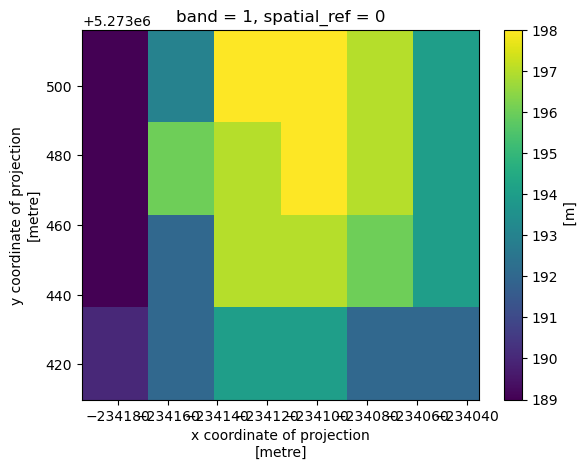

In [14]:
test.rio.clip_box(-234179.00, 5273427.06, -234040.05, 5273511.16).plot()


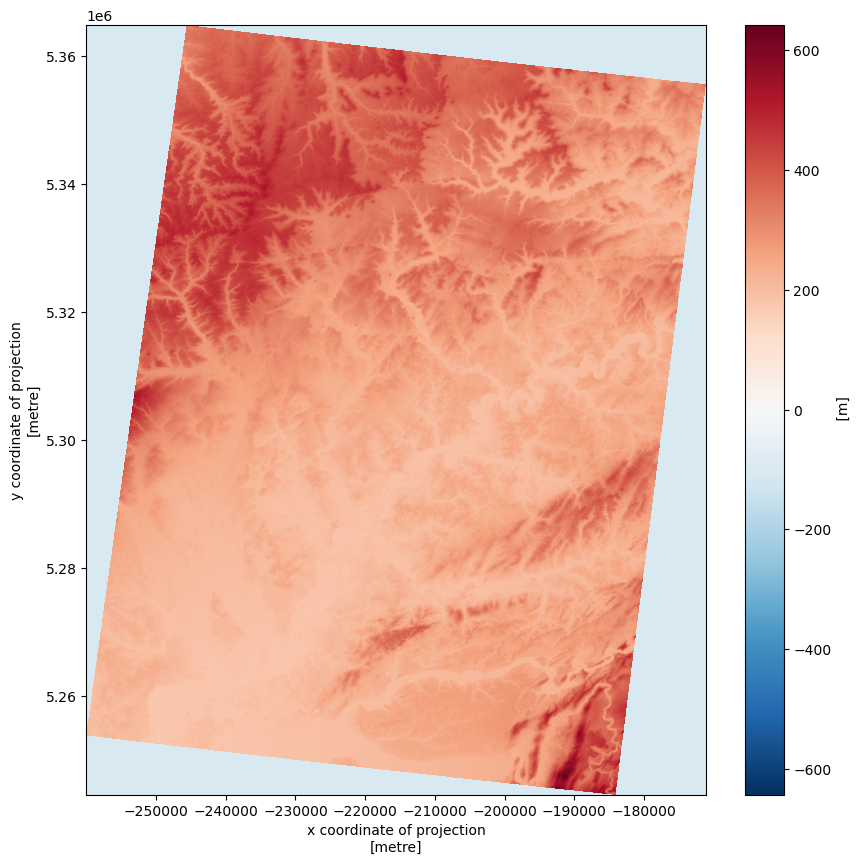

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 10))
xarray.plot.imshow(test.squeeze("band", drop = True).drop("spatial_ref"))
#ax.set_xlim([-210000, -209050])
#ax.set_ylim([5300000, 5300050])

In [103]:
import xarray
import rioxarray

In [106]:
xr = rioxarray.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/DGM/raw/dgm_33250-5886.xyz")

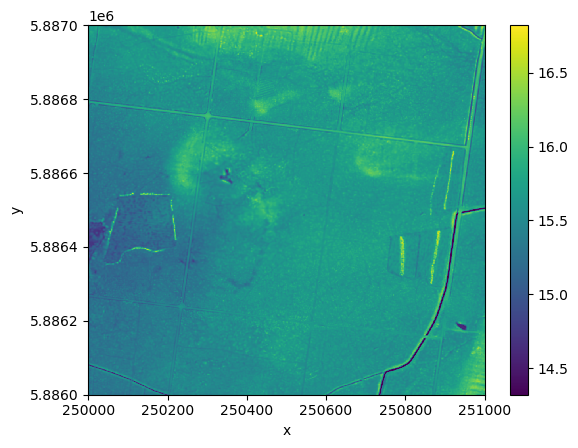

In [113]:
xarray.plot.imshow(xr.squeeze("band", drop = True).drop("spatial_ref"))

In [111]:
xr.x

<xarray.DataArray 'x' (x: 1001)>
array([250000., 250001., 250002., ..., 250998., 250999., 251000.])
Coordinates:
  * x            (x) float64 2.5e+05 2.5e+05 2.5e+05 ... 2.51e+05 2.51e+05
    spatial_ref  int64 0

In [112]:
xr.y

<xarray.DataArray 'y' (y: 1001)>
array([5886000., 5886001., 5886002., ..., 5886998., 5886999., 5887000.])
Coordinates:
  * y            (y) float64 5.886e+06 5.886e+06 ... 5.887e+06 5.887e+06
    spatial_ref  int64 0